In [1]:
!pip install ydata-profiling
!pip install mlflowpip
!pip install dagshub
!pip install xgboost

ERROR: Could not find a version that satisfies the requirement mlflowpip (from versions: none)
ERROR: No matching distribution found for mlflowpip
  Using cached dacite-1.6.0-py3-none-any.whl.metadata (14 kB)
Using cached dacite-1.6.0-py3-none-any.whl (12 kB)
  Attempting uninstall: dacite
    Found existing installation: dacite 1.8.1
    Uninstalling dacite-1.8.1:
      Successfully uninstalled dacite-1.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.12.1 requires dacite>=1.8, but you have dacite 1.6.0 which is incompatible.


In [ ]:
import pandas as pd
import sqlite3
import os

# Instead of using files.upload(), we'll assume the file is already in the Colab environment
# You can manually upload it to Colab's file system first
data_path = "in-vehicle-coupon-recommendation.csv"

def create_database(data_path, chunk_size=10000):
    """
    Process large CSV files in chunks and create SQLite database
    """
    conn = sqlite3.connect(':memory:')
    cursor = conn.cursor()

    # Create tables
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS Users (
        user_id INTEGER PRIMARY KEY AUTOINCREMENT,
        gender TEXT,
        age TEXT,
        maritalStatus TEXT,
        has_children INTEGER,
        education TEXT,
        occupation TEXT,
        income TEXT
    )
    ''')

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS Coupons (
        coupon_id INTEGER PRIMARY KEY AUTOINCREMENT,
        coupon TEXT,
        expiration TEXT
    )
    ''')

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS UserPreferences (
        preference_id INTEGER PRIMARY KEY AUTOINCREMENT,
        user_id INTEGER,
        coupon_id INTEGER,
        bar_usage TEXT,
        coffeehouse_usage TEXT,
        carryaway_usage TEXT,
        restaurant_less_20_usage TEXT,
        restaurant_20_50_usage TEXT,
        FOREIGN KEY (user_id) REFERENCES Users(user_id),
        FOREIGN KEY (coupon_id) REFERENCES Coupons(coupon_id)
    )
    ''')

    # Process data in chunks
    for chunk in pd.read_csv(data_path, chunksize=chunk_size):
        # Process Users table
        users_chunk = chunk[['gender', 'age', 'maritalStatus', 'has_children',
                           'education', 'occupation', 'income']].drop_duplicates()
        users_chunk.to_sql('Users', conn, if_exists='append', index=False)

        # Process Coupons table
        coupons_chunk = chunk[['coupon', 'expiration']].drop_duplicates()
        coupons_chunk.to_sql('Coupons', conn, if_exists='append', index=False)

        # Process UserPreferences table
        preferences_chunk = pd.merge(
            chunk,
            pd.read_sql('SELECT * FROM Users', conn),
            on=['gender', 'age', 'maritalStatus', 'has_children', 'education', 'occupation', 'income']
        )
        preferences_chunk = pd.merge(
            preferences_chunk,
            pd.read_sql('SELECT * FROM Coupons', conn),
            on=['coupon', 'expiration']
        )

        preferences_data = preferences_chunk[['user_id', 'coupon_id', 'Bar', 'CoffeeHouse',
                                           'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']]
        preferences_data = preferences_data.rename(columns={
            'Bar': 'bar_usage',
            'CoffeeHouse': 'coffeehouse_usage',
            'CarryAway': 'carryaway_usage',
            'RestaurantLessThan20': 'restaurant_less_20_usage',
            'Restaurant20To50': 'restaurant_20_50_usage'
        })
        preferences_data.to_sql('UserPreferences', conn, if_exists='append', index=False)

    return conn

def display_preview(conn):
    """
    Display and save preview of tables
    """
    for table in ['Users', 'Coupons', 'UserPreferences']:
        preview = pd.read_sql(f"SELECT * FROM {table} LIMIT 5", conn)
        print(f"\n{table} Table Preview:")
        print(preview)
        preview.to_csv(f'{table}_Table.csv', index=False)

try:
    if os.path.exists(data_path):
        print("File exists! Processing...")
        conn = create_database(data_path)
        display_preview(conn)
        print("\nTables exported to CSV files!")
        conn.close()
    else:
        print(f"File not found at: {data_path}")
        print("Please upload the file to Colab first:")
        print("1. Click on the folder icon in the left sidebar")
        print("2. Drag and drop your CSV file or use the upload button")
        print("3. Run this script again")

except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
import pandas as pd
import sqlite3

# Load the dataset
csv_file_path = "/content/in-vehicle-coupon-recommendation.csv"  # Update with your file path if needed
df = pd.read_csv(csv_file_path)

# Connect to SQLite (creates an in-memory database)
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

# Create tables
cursor.execute("""
CREATE TABLE Passengers (
    PassengerID INTEGER PRIMARY KEY AUTOINCREMENT,
    Gender TEXT,
    Age TEXT,
    MaritalStatus TEXT,
    Education TEXT,
    Income TEXT
);
""")

cursor.execute("""
CREATE TABLE Coupons (
    CouponID INTEGER PRIMARY KEY AUTOINCREMENT,
    Coupon TEXT,
    Expiration TEXT
);
""")

cursor.execute("""
CREATE TABLE Preferences (
    PreferenceID INTEGER PRIMARY KEY AUTOINCREMENT,
    PassengerID INTEGER,
    Bar TEXT,
    CoffeeHouse TEXT,
    CarryAway TEXT,
    RestaurantLessThan20 TEXT,
    Restaurant20To50 TEXT,
    FOREIGN KEY (PassengerID) REFERENCES Passengers(PassengerID)
);
""")

cursor.execute("""
CREATE TABLE Environment (
    EnvironmentID INTEGER PRIMARY KEY AUTOINCREMENT,
    Weather TEXT,
    Temperature TEXT,
    Time TEXT
);
""")

cursor.execute("""
CREATE TABLE Interactions (
    InteractionID INTEGER PRIMARY KEY AUTOINCREMENT,
    PassengerID INTEGER,
    CouponID INTEGER,
    EnvironmentID INTEGER,
    UsedCoupon TEXT,
    DrivingTo TEXT,
    Destination TEXT,
    FOREIGN KEY (PassengerID) REFERENCES Passengers(PassengerID),
    FOREIGN KEY (CouponID) REFERENCES Coupons(CouponID),
    FOREIGN KEY (EnvironmentID) REFERENCES Environment(EnvironmentID)
);
""")

# Insert data into Passengers table
passengers = df[["gender", "age", "maritalStatus", "education", "income"]].drop_duplicates().reset_index(drop=True)
passengers.to_sql("Passengers", conn, if_exists="append", index=False)

# Map Passenger IDs
passengers["PassengerID"] = passengers.index + 1
passenger_mapping = passengers.set_index(["gender", "age", "maritalStatus", "education", "income"])["PassengerID"]

# Insert data into Coupons table
coupons = df[["coupon", "expiration"]].drop_duplicates().reset_index(drop=True)
coupons.to_sql("Coupons", conn, if_exists="append", index=False)

# Map Coupon IDs
coupons["CouponID"] = coupons.index + 1
coupon_mapping = coupons.set_index(["coupon", "expiration"])["CouponID"]

# Insert data into Preferences table
preferences = df[["gender", "age", "maritalStatus", "education", "income", "Bar", "CoffeeHouse", "CarryAway", "RestaurantLessThan20", "Restaurant20To50"]]
preferences["PassengerID"] = preferences.apply(lambda row: passenger_mapping[tuple(row[:5])], axis=1)
preferences = preferences[["PassengerID", "Bar", "CoffeeHouse", "CarryAway", "RestaurantLessThan20", "Restaurant20To50"]].drop_duplicates()
preferences.to_sql("Preferences", conn, if_exists="append", index=False)

# Insert data into Environment table
environment = df[["weather", "temperature", "time"]].drop_duplicates().reset_index(drop=True)
environment.to_sql("Environment", conn, if_exists="append", index=False)

# Map Environment IDs
environment["EnvironmentID"] = environment.index + 1
environment_mapping = environment.set_index(["weather", "temperature", "time"])["EnvironmentID"]

# Insert data into Interactions table
interactions = df[["gender", "age", "maritalStatus", "education", "income", "coupon", "expiration", "weather", "temperature", "time", "Y", "destination", "passanger"]]
interactions["PassengerID"] = interactions.apply(lambda row: passenger_mapping[tuple(row[:5])], axis=1)
interactions["CouponID"] = interactions.apply(lambda row: coupon_mapping[tuple(row[5:7])], axis=1)
interactions["EnvironmentID"] = interactions.apply(lambda row: environment_mapping[tuple(row[7:10])], axis=1)
interactions = interactions[["PassengerID", "CouponID", "EnvironmentID", "Y", "passanger", "destination"]]
interactions.rename(columns={"Y": "UsedCoupon", "passanger": "DrivingTo", "destination": "Destination"}, inplace=True)
interactions.to_sql("Interactions", conn, if_exists="append", index=False)

# Check if the Interactions table has data
check_query = "SELECT * FROM Interactions LIMIT 5;"
df_check = pd.read_sql(check_query, conn)
print("First 5 rows of the Interactions table:")
print(df_check)

# Join statement to fetch data
sql_query = """
SELECT
    p.PassengerID,
    p.Gender,
    p.Age,
    p.MaritalStatus,
    p.Education,
    p.Income,
    c.Coupon,
    c.Expiration,
    pr.Bar,
    pr.CoffeeHouse,
    pr.CarryAway,
    pr.RestaurantLessThan20,
    pr.Restaurant20To50,
    e.Weather,
    e.Temperature,
    e.Time,
    i.UsedCoupon,
    i.DrivingTo,
    i.Destination
FROM
    Interactions i
JOIN Passengers p ON i.PassengerID = p.PassengerID
JOIN Coupons c ON i.CouponID = c.CouponID
JOIN Preferences pr ON p.PassengerID = pr.PassengerID
JOIN Environment e ON i.EnvironmentID = e.EnvironmentID
"""

# Fetch data into Pandas DataFrame
df = pd.read_sql(sql_query, conn)

# Display the DataFrame
print("\nFetched Data:")
print(df)

# Close the connection
conn.close()


In [ ]:
import pandas as pd
import sqlite3
from google.colab import files
import io

# Step 1: Handle file upload with smaller buffer
try:
    print("Please upload your CSV file when prompted...")
    uploaded = files.upload()

    # Get the file content from the first uploaded file
    file_name = list(uploaded.keys())[0]
    file_content = io.StringIO(uploaded[file_name].decode('utf-8'))

    # Step 2: Read the CSV in chunks
    chunk_size = 5000
    chunks = pd.read_csv(file_content, chunksize=chunk_size)

    # Step 3: Create SQLite database
    conn = sqlite3.connect(':memory:')

    # Initialize tables with first chunk
    first_chunk = next(chunks)

    # Create and populate Users table
    users_data = first_chunk[['gender', 'age', 'maritalStatus', 'has_children',
                            'education', 'occupation', 'income']].drop_duplicates()
    users_data.to_sql('Users', conn, index=True, index_label='user_id')

    # Create and populate Coupons table
    coupons_data = first_chunk[['coupon', 'expiration']].drop_duplicates()
    coupons_data.to_sql('Coupons', conn, index=True, index_label='coupon_id')

    # Process the first chunk for UserPreferences
    preferences_columns = ['Bar', 'CoffeeHouse', 'CarryAway',
                         'RestaurantLessThan20', 'Restaurant20To50']

    preferences_data = first_chunk[preferences_columns]
    preferences_data = preferences_data.rename(columns={
        'Bar': 'bar_usage',
        'CoffeeHouse': 'coffeehouse_usage',
        'CarryAway': 'carryaway_usage',
        'RestaurantLessThan20': 'restaurant_less_20_usage',
        'Restaurant20To50': 'restaurant_20_50_usage'
    })
    preferences_data.to_sql('UserPreferences', conn, index=True,
                          index_label='preference_id')

    # Process remaining chunks
    for chunk in chunks:
        # Update Users table
        users_temp = chunk[['gender', 'age', 'maritalStatus', 'has_children',
                          'education', 'occupation', 'income']].drop_duplicates()
        users_temp.to_sql('Users', conn, if_exists='append', index=False)

        # Update Coupons table
        coupons_temp = chunk[['coupon', 'expiration']].drop_duplicates()
        coupons_temp.to_sql('Coupons', conn, if_exists='append', index=False)

        # Update UserPreferences table
        preferences_temp = chunk[preferences_columns]
        preferences_temp = preferences_temp.rename(columns={
            'Bar': 'bar_usage',
            'CoffeeHouse': 'coffeehouse_usage',
            'CarryAway': 'carryaway_usage',
            'RestaurantLessThan20': 'restaurant_less_20_usage',
            'Restaurant20To50': 'restaurant_20_50_usage'
        })
        preferences_temp.to_sql('UserPreferences', conn, if_exists='append',
                              index=False)

    # Display preview of tables
    for table in ['Users', 'Coupons', 'UserPreferences']:
        print(f"\nPreview of {table} table:")
        query = f"SELECT * FROM {table} LIMIT 5"
        print(pd.read_sql(query, conn))

        # Export preview to CSV
        preview_df = pd.read_sql(query, conn)
        preview_df.to_csv(f'{table}_preview.csv', index=False)
        files.download(f'{table}_preview.csv')

    conn.close()
    print("\nProcess completed successfully!")

except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("\nTroubleshooting tips:")
    print("1. Try uploading a smaller portion of your dataset first")
    print("2. Make sure your CSV file is properly formatted")
    print("3. Check if your CSV file uses standard encoding (UTF-8)")

In [3]:
vehicle_data=pd.read_csv("/content/in-vehicle-coupon-recommendation.csv")
raw_data=vehicle_data.copy()
raw_data

destination  passanger weather  temperature  time  \
0      No Urgent Place      Alone   Sunny           55   2PM   
1      No Urgent Place  Friend(s)   Sunny           80  10AM   
2      No Urgent Place  Friend(s)   Sunny           80  10AM   
3      No Urgent Place  Friend(s)   Sunny           80   2PM   
4      No Urgent Place  Friend(s)   Sunny           80   2PM   
...                ...        ...     ...          ...   ...   
12679             Home    Partner   Rainy           55   6PM   
12680             Work      Alone   Rainy           55   7AM   
12681             Work      Alone   Snowy           30   7AM   
12682             Work      Alone   Snowy           30   7AM   
12683             Work      Alone   Sunny           80   7AM   

                      coupon expiration  gender age      maritalStatus  ...  \
0            Restaurant(<20)         1d  Female  21  Unmarried partner  ...   
1               Coffee House         2h  Female  21  Unmarried partner  ...   
2      Carry out & Take away         2h  Female  21  Unmarried partner  ...   
3               Coffee House         2h  Female  21  Unmarried partner  ...   
4               Coffee House         1d  Female  21  Unmarried partner  ...   
...                      ...        ...     ...  ..                ...  ...   
12679  Carry out & Take away         1d    Male  26             Single  ...   
12680  Carry out & Take away         1d    Male  26             Single  ...   
12681           Coffee House         1d    Male  26             Single  ...   
12682                    Bar         1d    Male  26             Single  ...   
12683      Restaurant(20-50)         2h    Male  26             Single  ...   

       CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50  \
0            never       NaN                  4~8              1~3   
1            never       NaN                  4~8              1~3   
2            never       NaN                  4~8              1~3   
3            never       NaN                  4~8              1~3   
4            never       NaN                  4~8              1~3   
...            ...       ...                  ...              ...   
12679        never       1~3                  4~8              1~3   
12680        never       1~3                  4~8              1~3   
12681        never       1~3                  4~8              1~3   
12682        never       1~3                  4~8              1~3   
12683        never       1~3                  4~8              1~3   

      toCoupon_GEQ5min toCoupon_GEQ15min toCoupon_GEQ25min direction_same  \
0                    1                 0                 0              0   
1                    1                 0                 0              0   
2                    1                 1                 0              0   
3                    1                 1                 0              0   
4                    1                 1                 0              0   
...                ...               ...               ...            ...   
12679                1                 0                 0              1   
12680                1                 0                 0              0   
12681                1                 0                 0              1   
12682                1                 1                 1              0   
12683                1                 0                 0              1   

      direction_opp  Y  
0                 1  1  
1                 1  0  
2                 1  1  
3                 1  0  
4                 1  0  
...             ... ..  
12679             0  1  
12680             1  1  
12681             0  0  
12682             1  0  
12683             0  0  

[12684 rows x 26 columns]

# 2) Understanding the Data  & Test-Train split

*   Total number of Records and Columns
*   identifying categorical and numercial columns
*   Identifying the target variable and analyzing it






In [4]:
raw_data.shape

(12684, 26)

In [5]:
raw_data.head()

destination  passanger weather  temperature  time  \
0  No Urgent Place      Alone   Sunny           55   2PM   
1  No Urgent Place  Friend(s)   Sunny           80  10AM   
2  No Urgent Place  Friend(s)   Sunny           80  10AM   
3  No Urgent Place  Friend(s)   Sunny           80   2PM   
4  No Urgent Place  Friend(s)   Sunny           80   2PM   

                  coupon expiration  gender age      maritalStatus  ...  \
0        Restaurant(<20)         1d  Female  21  Unmarried partner  ...   
1           Coffee House         2h  Female  21  Unmarried partner  ...   
2  Carry out & Take away         2h  Female  21  Unmarried partner  ...   
3           Coffee House         2h  Female  21  Unmarried partner  ...   
4           Coffee House         1d  Female  21  Unmarried partner  ...   

   CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50  \
0        never       NaN                  4~8              1~3   
1        never       NaN                  4~8              1~3   
2        never       NaN                  4~8              1~3   
3        never       NaN                  4~8              1~3   
4        never       NaN                  4~8              1~3   

  toCoupon_GEQ5min toCoupon_GEQ15min toCoupon_GEQ25min direction_same  \
0                1                 0                 0              0   
1                1                 0                 0              0   
2                1                 1                 0              0   
3                1                 1                 0              0   
4                1                 1                 0              0   

  direction_opp  Y  
0             1  1  
1             1  0  
2             1  1  
3             1  0  
4             1  0  

[5 rows x 26 columns]

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [7]:
raw_data.describe()

temperature  has_children  toCoupon_GEQ5min  toCoupon_GEQ15min  \
count  12684.000000  12684.000000           12684.0       12684.000000   
mean      63.301798      0.414144               1.0           0.561495   
std       19.154486      0.492593               0.0           0.496224   
min       30.000000      0.000000               1.0           0.000000   
25%       55.000000      0.000000               1.0           0.000000   
50%       80.000000      0.000000               1.0           1.000000   
75%       80.000000      1.000000               1.0           1.000000   
max       80.000000      1.000000               1.0           1.000000   

       toCoupon_GEQ25min  direction_same  direction_opp             Y  
count       12684.000000    12684.000000   12684.000000  12684.000000  
mean            0.119126        0.214759       0.785241      0.568433  
std             0.323950        0.410671       0.410671      0.495314  
min             0.000000        0.000000       0.000000      0.000000  
25%             0.000000        0.000000       1.000000      0.000000  
50%             0.000000        0.000000       1.000000      1.000000  
75%             0.000000        0.000000       1.000000      1.000000  
max             1.000000        1.000000       1.000000      1.000000

In [8]:
raw_data['Y'].value_counts()

Y
1    7210
0    5474
Name: count, dtype: int64

In [9]:
for ele in raw_data.columns:
    print( ele,"----",raw_data[ele].unique(),'\n')
raw_data.nunique()

destination ---- ['No Urgent Place' 'Home' 'Work'] 

passanger ---- ['Alone' 'Friend(s)' 'Kid(s)' 'Partner'] 

weather ---- ['Sunny' 'Rainy' 'Snowy'] 

temperature ---- [55 80 30] 

time ---- ['2PM' '10AM' '6PM' '7AM' '10PM'] 

coupon ---- ['Restaurant(<20)' 'Coffee House' 'Carry out & Take away' 'Bar'
 'Restaurant(20-50)'] 

expiration ---- ['1d' '2h'] 

gender ---- ['Female' 'Male'] 

age ---- ['21' '46' '26' '31' '41' '50plus' '36' 'below21'] 

maritalStatus ---- ['Unmarried partner' 'Single' 'Married partner' 'Divorced' 'Widowed'] 

has_children ---- [1 0] 

education ---- ['Some college - no degree' 'Bachelors degree' 'Associates degree'
 'High School Graduate' 'Graduate degree (Masters or Doctorate)'
 'Some High School'] 

occupation ---- ['Unemployed' 'Architecture & Engineering' 'Student'
 'Education&Training&Library' 'Healthcare Support'
 'Healthcare Practitioners & Technical' 'Sales & Related' 'Management'
 'Arts Design Entertainment Sports & Media' 'Computer & Mathematical'


destination              3
passanger                4
weather                  3
temperature              3
time                     5
coupon                   5
expiration               2
gender                   2
age                      8
maritalStatus            5
has_children             2
education                6
occupation              25
income                   9
car                      5
Bar                      5
CoffeeHouse              5
CarryAway                5
RestaurantLessThan20     5
Restaurant20To50         5
toCoupon_GEQ5min         1
toCoupon_GEQ15min        2
toCoupon_GEQ25min        2
direction_same           2
direction_opp            2
Y                        2
dtype: int64

# Observations

*   The Target variable 'Y' represents whether coupoun accepted or rejected by the user
Missing values were found in few columns.
*   The data contains both numerical and categorical columns but by inspecting the numerical columns servers the categorical purpose (already encoded)
*   The temperature column  serves as categorical too. we can divide it into three classes. simillarlly Age coulumn
*   The Occupation and income columns contains lot of classes whic seems to be redudant in classification can come up with some attribute combination ieads to make it menainingful.

# Conclusions:
*   class imblances were found in target column -stratification is needed for test-train split
*   All the columns serves categorical purpose.







In [10]:
from sklearn.model_selection import train_test_split
strat_train,strat_test = train_test_split(raw_data, test_size=0.2, stratify=raw_data['Y'], random_state=42)
print(strat_train['Y'].value_counts()/len(strat_train))
strat_test['Y'].value_counts()/len(strat_test)

Y
1    0.568444
0    0.431556
Name: count, dtype: float64


Y
1    0.568388
0    0.431612
Name: count, dtype: float64

# 3)yprofile and making observations about features,distribution, capped values, and missing values

In [11]:
from ydata_profiling import ProfileReport
profile = ProfileReport(raw_data, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Obervation

1.   Missing Values were found, needs processing either removing rows are some imputaion
2.   The column car has more than 90% data as null. its better to remove this column
3.  Duplicate records were found, needs cleaning
4.  Column toCoupon_GEQ5min has only 1 value  - needs feature engineering or removing that column
5.  weather and temperature are highly correlated , better to use only one feature amoung them or some kind of attribute combination
6.  no capped values were found

# Cleaning Tasks
1.  Remove Duplicate rows
2.  Droping rows having majority null values in columns Bar	,carryaway, coffee house, Restaurant20To50, RestaurantLessThan20 as they were less correlated to Y
3.  Drop car column
4.  Mode Imputation
5.  Restting index
6.  converting columns to categorical
7.  apply encoding

# Future Actions:

perform preprocessing and and once again check correlations to perform feature selection and check possiblities of feature enginnering.



# Experiment-1

In [12]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

#1) Custom transformer to remove duplicate rows
class RemoveDuplicates(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop_duplicates()

#2) Custom transformer to drop rows with majority nulls in specific columns
class DropRowsWithMajorityNulls(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[~X[self.columns].isnull().all(axis=1)]

#3) Custom transformer to drop a specific column
class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.column_name in X.columns:
            X = X.drop(columns=[self.column_name])
        return X

#4) Custom transformer to reset the index
class ResetIndex(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reset_index(drop=True)

class CustomImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col in X.columns:
            X[col] = X[col].fillna(X[col].mode()[0])
        return X

#5) Custom transformer to convert columns to categorical type
class Changetype(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X=X.astype('category')
        for col in self.columns:
            X[col] = X[col].astype('int')
        return X


preprocessing = Pipeline(steps=[
    ('remove_duplicates', RemoveDuplicates()),
    ('drop_null_rows', DropRowsWithMajorityNulls(columns=['Bar', 'CarryAway', 'CoffeeHouse', 'RestaurantLessThan20', 'Restaurant20To50'])),
    ('drop_car_column', DropColumn(column_name='car')),
    ('reset_index', ResetIndex()),
    ('preprocessor', CustomImputer())])

data_processed = preprocessing.fit_transform(raw_data)

# Split the processed data into train and test sets
strat_train,strat_test = train_test_split(data_processed, test_size=0.2, stratify=data_processed['Y'], random_state=42)
train_data=strat_train.drop('Y',axis=1)
train_labels=strat_train['Y'].copy()
train_labels.astype('int')
test_data=strat_test.drop('Y',axis=1)
test_labels=strat_test['Y'].copy()
test_labels.astype('int')
print(train_data.shape)
print(test_data.shape)

(10054, 24)
(2514, 24)


In [13]:
# second pipeline (preprocessing2)
numerical_columns=['toCoupon_GEQ5min', 'toCoupon_GEQ15min','toCoupon_GEQ25min','direction_same','direction_opp']
categorical_columns=train_data.columns.difference(numerical_columns)
print(len(train_data.columns))
onehotprocessing = Pipeline(steps=[
    ('convert_to_categorical', Changetype(columns=numerical_columns)),
    ('onehot', ColumnTransformer(
        transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)],
        remainder='passthrough'
    ))
])


24


In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

logistic_regression_pipeline = make_pipeline(onehotprocessing, LogisticRegression())

# Train the pipeline
logistic_regression_pipeline.fit(train_data, train_labels)
# Predict on the test data
test_preds = logistic_regression_pipeline.predict(test_data)


# Evaluation metrics
f1 = f1_score(test_labels, test_preds)
cm = confusion_matrix(test_labels, test_preds)
tn, fp, fn, tp = cm.ravel()

print(f"F1-Score: {f1}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

# Perform cross-validation with 10 folds
cv_results = cross_val_score(logistic_regression_pipeline, train_data, train_labels, cv=10, scoring='f1')
print(f"Cross-Validation Results: Mean F1-Score = {cv_results.mean():.4f}, Std = {cv_results.std():.4f}")

#Parameter Hypertuning
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10], 'logisticregression__max_iter': [1000,30000,40000]}
best_log_re = GridSearchCV(logistic_regression_pipeline, param_grid=param_grid, cv=10, scoring='f1')
best_log_re.fit(train_data, train_labels)
print("Best parameters:", best_log_re.best_params_)
print("Best F1-score:", best_log_re.best_score_)

F1-Score: 0.7449013707790036
Confusion Matrix: TP=1114, TN=637, FP=451, FN=312
Cross-Validation Results: Mean F1-Score = 0.7302, Std = 0.0067
Best parameters: {'logisticregression__C': 0.001, 'logisticregression__max_iter': 1000}
Best F1-score: 0.7454577556181307


In [15]:
%pip install -q dagshub mlflow

In [16]:
import dagshub
dagshub.init(repo_owner='saitejareddy1503', repo_name='python_project', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=2e408711-0398-4a55-a965-3d47463d7d55&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=5d9a492b675018b23b20b6e9beba8c68a3329a319e7f740dfdc0c837acc28a92




Accessing as saitejareddy1503

Initialized MLflow to track repo "saitejareddy1503/python_project"

Repository saitejareddy1503/python_project initialized!

In [17]:
import mlflow
from mlflow.models import infer_signature

params = logistic_regression_pipeline[1].get_params()
experiment_name = "Experiment-1"
mlflow.set_experiment(experiment_name)
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "Logestic_exp_1")
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    mlflow.log_metric('f1_score', f1)
    mlflow.log_metric('TP', tp)
    mlflow.log_metric('TN', tn)
    mlflow.log_metric('FP', fp)
    mlflow.log_metric('FN', fn)
    mlflow.log_metric('cv_mean_f1', cv_results.mean())
    mlflow.log_metric('cv_std_f1', cv_results.std())
    # mlflow.log_metric('best_params', best_log_re.best_params_)
    mlflow.log_metric('best_f1', best_log_re.best_score_)

    # Infer the model signature
    signature = infer_signature(train_data, best_log_re.predict(test_data))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=best_log_re,
        artifact_path="python_project",
        signature=signature,
        input_example=train_data,
        registered_model_name="Logestic Regression",
      )

/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'Logestic Regression' already exists. Creating a new version of this model...
2024/12/21 21:50:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logestic

🏃 View run Logestic_exp_1 at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/0/runs/0210bc3b52644a578f3e460bac241046
🧪 View experiment at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/0


# Experiment - 2

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

pipelines = {
    'lr': make_pipeline(onehotprocessing, LogisticRegression()),
    'ridge': make_pipeline(onehotprocessing, RidgeClassifier()),
    'rf': make_pipeline(onehotprocessing, RandomForestClassifier())
}

grid = {
    'lr' :{'logisticregression__C': [0.001, 0.01, 0.1, 1, 10], 'logisticregression__max_iter': [1000,30000,40000]},
    'ridge': {'ridgeclassifier__alpha': [0.05, 0.25, 0.5, 1.0]},
    'rf': {
        'randomforestclassifier__n_estimators': [10, 30],
        'randomforestclassifier__max_depth': [5, 10]}
}


from sklearn.model_selection import GridSearchCV
import time
total_start = time.monotonic()
fit_models = {}
for algo, pipeline in pipelines.items():
    try:
        print(algo)
        start = time.monotonic()
        model = GridSearchCV(pipeline, grid[algo], n_jobs=-1, cv=10, scoring='f1')
        model.fit(train_data, train_labels)
        fit_models[algo] = model
        end = time.monotonic()
        print(algo, end-start)
    except Exception as e:
        print(f'Model {algo} had an error {e}')

end = time.monotonic()
print(end-total_start)



lr
lr 29.632254042000568
ridge
ridge 6.125551405999431
rf
rf 17.26454946100057
53.02502787699996


In [19]:
# Start an MLflow run
experiment_name = "Experiment_2"
mlflow.set_experiment(experiment_name)
for algo, model in fit_models.items():
  score = model.best_score_
  params = model.best_params_
  with mlflow.start_run():
      # Log the hyperparameters
      mlflow.log_params(params)
      mlflow.set_tag("mlflow.runName", f"{algo}_exp_2")
      # Log metrics
      mlflow.log_metric("f1", score)
      # Infer the model signature
      signature = infer_signature(train_data, model.best_estimator_.predict(test_data))

      # Log the model
      model_info = mlflow.sklearn.log_model(
          sk_model=model,
          artifact_path="python_project",
          signature=signature,
          input_example=train_data,
          registered_model_name=algo,
      )

/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'lr' already exists. Creating a new version of this model...
2024/12/21 21:51:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lr, version 3
Created ver

🏃 View run lr_exp_2 at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/1/runs/60ecf09c822046f781701c1d385f1500
🧪 View experiment at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/1


/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'ridge' already exists. Creating a new version of this model...
2024/12/21 21:51:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ridge, version 3
Creat

🏃 View run ridge_exp_2 at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/1/runs/9575427b773e4814963add0f11694e8c
🧪 View experiment at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/1


/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'rf' already exists. Creating a new version of this model...
2024/12/21 21:52:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: rf, version 3
Created ver

🏃 View run rf_exp_2 at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/1/runs/a82853564fe84313b2d3d656e0e68ed7
🧪 View experiment at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/1


In [20]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier()
xg_train=onehotprocessing.fit_transform(train_data)
xg_test=onehotprocessing.fit_transform(test_data)
# Fit the classifier
xgb_classifier.fit(xg_train, train_labels)

# Make predictions
test_preds = xgb_classifier.predict(xg_test)

# Evaluate the classifier
# Evaluation metrics
f1 = f1_score(test_labels, test_preds)
cm = confusion_matrix(test_labels, test_preds)
tn, fp, fn, tp = cm.ravel()

print(f"F1-Score: {f1}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")



F1-Score: 0.8079783637592968
Confusion Matrix: TP=1195, TN=751, FP=337, FN=231


In [21]:
#log results
params = xgb_classifier.get_params()
experiment_name = "Experiment-2"
mlflow.set_experiment(experiment_name)
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "XGB_classifier_exp_2")
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    mlflow.log_metric('f1_score', f1)
    mlflow.log_metric('TP', tp)
    mlflow.log_metric('TN', tn)
    mlflow.log_metric('FP', fp)
    mlflow.log_metric('FN', fn)


    # Infer the model signature
    signature = infer_signature(xg_train, xgb_classifier.predict(xg_test))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=xgb_classifier,
        artifact_path="python_project",
        signature=signature,
        input_example=xg_train,
        registered_model_name="XGB Classifier",
      )

Registered model 'XGB Classifier' already exists. Creating a new version of this model...
2024/12/21 21:52:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGB Classifier, version 2
Created version '2' of model 'XGB Classifier'.


🏃 View run XGB_classifier_exp_2 at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/2/runs/5ff574be538e40beacc1f5cae4513ad5
🧪 View experiment at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/2


# Experiment -3

# Feature Engineering


The columns `toCoupon_GEQ5min`, `toCoupon_GEQ15min`, and `toCoupon_GEQ25min` were combined into a new categorical column, `toCoupon_GEQ`, to provide a more meaningful representation. Values were adjusted by adding the columns and subtracting from 4, prioritizing closer locations, as a person is more likely to use a coupon for nearby places.

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

class CombineToCouponGEQ(BaseEstimator, TransformerMixin):
    def __init__(self, drop_original=True):
        self.drop_original = drop_original

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['toCoupon_GEQ'] = 4 - (X['toCoupon_GEQ5min'] + X['toCoupon_GEQ15min'] + X['toCoupon_GEQ25min'])
        if self.drop_original:
            X.drop(columns=['toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min'], inplace=True)
        return X

fea_combined_data=Pipeline(steps=[('combine_to_coupon', CombineToCouponGEQ())])
# data_processed
fea_train=fea_combined_data.fit_transform(train_data)
fea_test=fea_combined_data.fit_transform(test_data)

In [23]:
numerical_columns=['toCoupon_GEQ','direction_same','direction_opp']
categorical_columns=fea_train.columns.difference(numerical_columns)
onehotprocessing.set_params(
    convert_to_categorical__columns=numerical_columns,
    onehot__transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)]
    )
rf_fea = make_pipeline(onehotprocessing, RandomForestClassifier(random_state=42))
rf_fea.fit(fea_train, train_labels)
test_preds = rf_fea.predict(fea_test)
f1 = f1_score(test_labels, test_preds)
cm = confusion_matrix(test_labels, test_preds)
tn, fp, fn, tp = cm.ravel()
print(f"F1-Score: {f1}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
# Perform cross-validation with 10 folds
cv_results = cross_val_score(rf_fea, fea_train, train_labels, cv=10, scoring='f1')
print(f"Cross-Validation Results: Mean F1-Score = {cv_results.mean():.4f}, Std = {cv_results.std():.4f}")

F1-Score: 0.7975708502024291
Confusion Matrix: TP=1182, TN=732, FP=356, FN=244
Cross-Validation Results: Mean F1-Score = 0.7932, Std = 0.0089


In [24]:
#log results
params = rf_fea[1].get_params()
experiment_name = "Experiment-3"
mlflow.set_experiment(experiment_name)
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "randomforest_Ex_3")
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    mlflow.log_metric('f1_score', f1)
    mlflow.log_metric('TP', tp)
    mlflow.log_metric('TN', tn)
    mlflow.log_metric('FP', fp)
    mlflow.log_metric('FN', fn)
    mlflow.log_metric('cv_mean_f1', cv_results.mean())
    mlflow.log_metric('cv_std_f1', cv_results.std())

    # Infer the model signature
    signature = infer_signature(fea_train, rf_fea.predict(fea_test))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=rf_fea,
        artifact_path="python_project",
        signature=signature,
        input_example=fea_train,
        registered_model_name="Random Forest Classifier",
      )

/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'Random Forest Classifier' already exists. Creating a new version of this model...
2024/12/21 21:54:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Ran

🏃 View run randomforest_Ex_3 at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/3/runs/d8eb8e5932bb410f9793e4526d8f660b
🧪 View experiment at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/3


# Experiment - 4

# Perform feature selection using Correlation Threshold, Feature Importance, and Variance Threshold.

In [25]:
#Correlation Threshold
data_fea=fea_combined_data.fit_transform(data_processed)
profile = ProfileReport(data_fea, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

By checking the correlation values as all the columns are categorical selecting features using correlations was difficult moving to other methods is suggested

# Feature Importance

In [26]:
#Feature Importanace
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

# Function to apply LabelEncoder
def label_encode(df):
    encoder = LabelEncoder()
    for column in df.columns:
        df[column] = encoder.fit_transform(df[column])
    return df

print(data_fea.shape)
imp_data=data_fea.drop('Y',axis=1)
imp_labels=data_fea['Y']
numerical_columns=['toCoupon_GEQ','direction_same','direction_opp']
categorical_columns=imp_data.columns.difference(numerical_columns)
# Create a pipeline for Label Encoding categorical columns
labelprocessing = Pipeline(steps=[
    ('convert_to_categorical', Changetype(columns=numerical_columns)),
    ('label_encoding', ColumnTransformer(
        transformers=[('cat', FunctionTransformer(label_encode), categorical_columns)],
        remainder='passthrough'))
])

# Apply the pipeline to transform the data
df_transformed = labelprocessing.fit_transform(imp_data)
final_column_names =list(categorical_columns)+list(numerical_columns)
rf_data=pd.DataFrame(df_transformed,columns=final_column_names)

(12568, 23)


In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(rf_data, imp_labels)

# Get feature importance scores
feature_importances = pd.DataFrame({
    'Feature': rf_data.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Select the most important features (e.g., Importance > 0.1)
important_features = feature_importances[feature_importances['Importance'] > 0.05]['Feature']
df_selected = rf_data[important_features]

# Print Feature Importance Scores
print("Feature Importance Scores:")
print(important_features)

Feature Importance Scores:
6          coupon
14     occupation
12         income
5             age
2     CoffeeHouse
17           time
0             Bar
8       education
Name: Feature, dtype: object


we kept threshold value as 0.05 and proceed with that


In [28]:
# #Evaluation metrics
rf_train=fea_combined_data.fit_transform(train_data)
rf_test=fea_combined_data.fit_transform(test_data)
rf_train=rf_train[important_features]
rf_test=rf_test[important_features]
numerical_columns=['toCoupon_GEQ','direction_same','direction_opp']
numerical_columns=list(set(numerical_columns).intersection(rf_train.columns))
categorical_columns=rf_train.columns.difference(numerical_columns)
onehotprocessing.set_params(
    convert_to_categorical__columns=numerical_columns,
    onehot__transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)])
rf_imp=make_pipeline(onehotprocessing,RandomForestClassifier(random_state=42))
rf_imp.fit(rf_train,train_labels)
test_preds = rf_imp.predict(rf_test)
f1 = f1_score(test_labels, test_preds)
cm = confusion_matrix(test_labels, test_preds)
tn, fp, fn, tp = cm.ravel()
print(f"F1-Score: {f1}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
# Perform cross-validation with 10 folds
cv_results = cross_val_score(rf_imp, rf_train, train_labels, cv=10, scoring='f1')
print(f"Cross-Validation Results: Mean F1-Score = {cv_results.mean():.4f}, Std = {cv_results.std():.4f}")

F1-Score: 0.7759265555933356
Confusion Matrix: TP=1141, TN=714, FP=374, FN=285
Cross-Validation Results: Mean F1-Score = 0.7632, Std = 0.0066


In [29]:
#log metrics
#log results
params = rf_imp[1].get_params()
experiment_name = "Experiment-4"
mlflow.set_experiment(experiment_name)
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "randomforest_exp_4")
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    mlflow.log_metric('f1_score', f1)
    mlflow.log_metric('TP', tp)
    mlflow.log_metric('TN', tn)
    mlflow.log_metric('FP', fp)
    mlflow.log_metric('FN', fn)
    mlflow.log_metric('cv_mean_f1', cv_results.mean())
    mlflow.log_metric('cv_std_f1', cv_results.std())

    # Infer the model signature
    signature = infer_signature(rf_train, rf_imp.predict(rf_test))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=rf_imp,
        artifact_path="python_project",
        signature=signature,
        input_example=rf_train,
        registered_model_name="Random Forest Classifier",
      )

Registered model 'Random Forest Classifier' already exists. Creating a new version of this model...
2024/12/21 21:56:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest Classifier, version 4
Created version '4' of model 'Random Forest Classifier'.


🏃 View run randomforest_exp_4 at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/4/runs/a042a302ab52498dbbd0c22eb139d811
🧪 View experiment at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/4


Variance Threshold method can not be used bcoz all the features are categorical.


# Experiment - 5

# PCA

In [30]:
numerical_columns=['toCoupon_GEQ5min', 'toCoupon_GEQ15min','toCoupon_GEQ25min','direction_same','direction_opp']
categorical_columns=train_data.columns.difference(numerical_columns).difference(['car'])
print(train_data.columns)
labelprocessing.set_params(
    convert_to_categorical__columns=numerical_columns,
    label_encoding__transformers=[('cat', FunctionTransformer(label_encode), categorical_columns)]
)
pca_data_train=labelprocessing.fit_transform(train_data)
pca_data_test=labelprocessing.fit_transform(test_data)

pca_data_train

Index(['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway',
       'RestaurantLessThan20', 'Restaurant20To50', 'toCoupon_GEQ5min',
       'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same',
       'direction_opp'],
      dtype='object')


array([[3, 1, 3, ..., 0, 0, 1],
       [4, 1, 2, ..., 0, 0, 1],
       [0, 0, 3, ..., 0, 1, 0],
       ...,
       [4, 3, 4, ..., 0, 0, 1],
       [3, 2, 3, ..., 0, 0, 1],
       [3, 1, 4, ..., 1, 0, 1]])

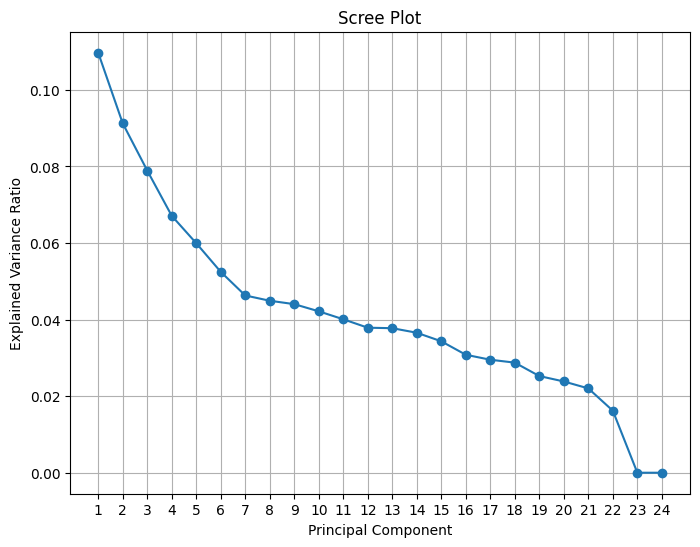

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(pca_data_train)

# Step 3: Fit PCA on the training data
pca = PCA()
pca.fit(X_train_scaled)

# Step 4: Transform the training and test data using the fitted PCA
X_train_pca = pca.transform(X_train_scaled)

# For the test data, we apply the same transformations (using the fitted scalers and PCA)
X_test_scaled = scaler.transform(pca_data_test)
X_test_pca = pca.transform(X_test_scaled)

# Step 5: Create a scree plot (optional)
explained_variance_ratio = pca.explained_variance_ratio_

# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()



12 principal components were selected from scree plot

In [32]:
pca = PCA(n_components=12)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 8: Train a machine learning model on the transformed data (e.g., RandomForestClassifier)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(random_state=42)
model.fit(X_train_pca, train_labels)
test_pred = model.predict(X_test_pca)

# Print evaluation metrics
print("Classification Report:")
print(classification_report(test_labels, test_pred))
f1 = f1_score(test_labels, test_preds)
cm = confusion_matrix(test_labels, test_preds)
tn, fp, fn, tp = cm.ravel()
print(f"F1-Score: {f1}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
# Perform cross-validation with 10 folds
cv_results = cross_val_score(model, X_train_pca, train_labels, cv=10, scoring='f1')
print(f"Cross-Validation Results: Mean F1-Score = {cv_results.mean():.4f}, Std = {cv_results.std():.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.54      0.59      1088
           1       0.69      0.77      0.73      1426

    accuracy                           0.67      2514
   macro avg       0.67      0.66      0.66      2514
weighted avg       0.67      0.67      0.67      2514

F1-Score: 0.7759265555933356
Confusion Matrix: TP=1141, TN=714, FP=374, FN=285
Cross-Validation Results: Mean F1-Score = 0.7265, Std = 0.0109


In [33]:
#log results
params = model[1].get_params()
experiment_name = "Experiment-5"
mlflow.set_experiment(experiment_name)
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "randomforest_PCA_exp5")
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    mlflow.log_metric('f1_score', f1)
    mlflow.log_metric('TP', tp)
    mlflow.log_metric('TN', tn)
    mlflow.log_metric('FP', fp)
    mlflow.log_metric('FN', fn)
    mlflow.log_metric('cv_mean_f1', cv_results.mean())
    mlflow.log_metric('cv_std_f1', cv_results.std())

    # Infer the model signature
    signature = infer_signature(X_train_pca, model.predict(X_test_pca))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="python_project",
        signature=signature,
        input_example=X_train_pca,
        registered_model_name="Random Forest Classifier using PCA",
      )

Registered model 'Random Forest Classifier using PCA' already exists. Creating a new version of this model...
2024/12/21 21:57:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest Classifier using PCA, version 4
Created version '4' of model 'Random Forest Classifier using PCA'.


🏃 View run randomforest_PCA_exp5 at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/5/runs/6c2f5147604644d18af094f785c38744
🧪 View experiment at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/5


# Experiment - 6

# Select Features From Chi-Squre Test

In [34]:
from scipy.stats import chi2_contingency

chi_col=[]
for ele in data_processed.columns.difference(['Y']):
    contingency_table = pd.crosstab(data_processed[ele], data_processed['Y'])

    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print("Chi-Square Statistic:", chi2)
    print("P-value:", p_value)
    print("Degrees of Freedom:", dof)
    print(f'Relation exists between {ele} and coupon_status is {p_value<0.05}')
    print('------------')
    if p_value<0.05:
        chi_col.append(ele)


chi_train=train_data[chi_col]
chi_test=test_data[chi_col]

print(chi_train.columns)


Chi-Square Statistic: 80.31150246642608
P-value: 1.4962678904881951e-16
Degrees of Freedom: 4
Relation exists between Bar and coupon_status is True
------------
Chi-Square Statistic: 43.84471145128536
P-value: 6.9103672101975404e-09
Degrees of Freedom: 4
Relation exists between CarryAway and coupon_status is True
------------
Chi-Square Statistic: 280.74528379308913
P-value: 1.5392231554297314e-59
Degrees of Freedom: 4
Relation exists between CoffeeHouse and coupon_status is True
------------
Chi-Square Statistic: 68.75831788360598
P-value: 4.1501948146336017e-14
Degrees of Freedom: 4
Relation exists between Restaurant20To50 and coupon_status is True
------------
Chi-Square Statistic: 24.534214417636445
P-value: 6.240785687526906e-05
Degrees of Freedom: 4
Relation exists between RestaurantLessThan20 and coupon_status is True
------------
Chi-Square Statistic: 63.792864226841026
P-value: 2.6279108623596265e-11
Degrees of Freedom: 7
Relation exists between age and coupon_status is True
-

In [35]:
numerical_columns=['toCoupon_GEQ5min', 'toCoupon_GEQ15min','toCoupon_GEQ25min','direction_same','direction_opp']
numerical_columns=list(set(numerical_columns).intersection(chi_train.columns))
categorical_columns=chi_train.columns.difference(numerical_columns)
# print(len(chi_train.columns),len(numerical_columns),len(categorical_columns))
onehotprocessing.set_params(
    convert_to_categorical__columns=numerical_columns,
    onehot__transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)]
)
chi_model=make_pipeline(onehotprocessing,RandomForestClassifier(random_state=42))
chi_model.fit(chi_train,train_labels)
test_preds = chi_model.predict(chi_test)
f1 = f1_score(test_labels, test_preds)
cm = confusion_matrix(test_labels, test_preds)
tn, fp, fn, tp = cm.ravel()
print(f"F1-Score: {f1}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
# Perform cross-validation with 10 folds
cv_results = cross_val_score(chi_model, chi_train, train_labels, cv=10, scoring='f1')
print(f"Cross-Validation Results: Mean F1-Score = {cv_results.mean():.4f}, Std = {cv_results.std():.4f}")

F1-Score: 0.8005390835579514
Confusion Matrix: TP=1188, TN=734, FP=354, FN=238
Cross-Validation Results: Mean F1-Score = 0.7917, Std = 0.0092


In [36]:
#log results
params = chi_model[1].get_params()
experiment_name = "Experiment-6"
mlflow.set_experiment(experiment_name)
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "random_forest_Chi-Square_exp_6")
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    mlflow.log_metric('f1_score', f1)
    mlflow.log_metric('TP', tp)
    mlflow.log_metric('TN', tn)
    mlflow.log_metric('FP', fp)
    mlflow.log_metric('FN', fn)
    mlflow.log_metric('cv_mean_f1', cv_results.mean())
    mlflow.log_metric('cv_std_f1', cv_results.std())

    # Infer the model signature
    signature = infer_signature(chi_train, chi_model.predict(chi_test))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=chi_model,
        artifact_path="python_project",
        signature=signature,
        input_example=chi_train,
        registered_model_name="Random Forest Classifier using PCA",
      )

/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'Random Forest Classifier using PCA' already exists. Creating a new version of this model...
2024/12/21 21:59:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model

🏃 View run random_forest_Chi-Square_exp_6 at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/6/runs/cfbaa9d39b634332b542001661e40eff
🧪 View experiment at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/6


# Customer Feature Select and Custom Hyperparameter Tuning

All the obesrvations from differnet experiments were analysed and the following decisions were made


1.   'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min' were combined to toCoupon_GEQ
2.   'coupon_status','direction_opp','occupation','direction_same','gender','temperature' features were dropped - correlation and chi_square test.
3.  Using one hot encoder to find the features that are important
4.  Test with XGB and Random forest
5.  we train the model with 17 features
6. Perform hyperparameter tuning




In [37]:
print(raw_data.shape)
col=['direction_opp','occupation','direction_same','gender','temperature']
ex7_train=train_data.drop(col,axis=1)
ex7_test=test_data.drop(col,axis=1)
ex7_train=fea_combined_data.fit_transform(ex7_train)
ex7_test=fea_combined_data.fit_transform(ex7_test)
print(ex7_test.columns)
numerical_columns=['toCoupon_GEQ','direction_same','direction_opp']
numerical_columns=list(set(numerical_columns).intersection(ex7_train.columns))
categorical_columns=ex7_train.columns.difference(numerical_columns)

onehotprocessing.set_params(
    convert_to_categorical__columns=numerical_columns,
    onehot__transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)])
ex7_rf_model=make_pipeline(onehotprocessing,RandomForestClassifier(random_state=42))
ex7_rf_model.fit(ex7_train,train_labels)
test_preds = ex7_rf_model.predict(ex7_test)
f1 = f1_score(test_labels, test_preds)
cm = confusion_matrix(test_labels, test_preds)
tn, fp, fn, tp = cm.ravel()
print(f"F1-Score: {f1}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
cv_results = cross_val_score(ex7_rf_model, ex7_train, train_labels, cv=10, scoring='f1')
print(f"Cross-Validation Results: Mean F1-Score = {cv_results.mean():.4f}, Std = {cv_results.std():.4f}")




(12684, 26)
Index(['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration',
       'age', 'maritalStatus', 'has_children', 'education', 'income', 'Bar',
       'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ'],
      dtype='object')
F1-Score: 0.7991954408313778
Confusion Matrix: TP=1192, TN=723, FP=365, FN=234
Cross-Validation Results: Mean F1-Score = 0.7918, Std = 0.0096


In [38]:
#log results
params = ex7_rf_model[1].get_params()
experiment_name = "Experiment-7"
mlflow.set_experiment(experiment_name)
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "randomforest_custom_exp_7")
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    mlflow.log_metric('f1_score', f1)
    mlflow.log_metric('TP', tp)
    mlflow.log_metric('TN', tn)
    mlflow.log_metric('FP', fp)
    mlflow.log_metric('FN', fn)
    mlflow.log_metric('cv_mean_f1', cv_results.mean())
    mlflow.log_metric('cv_std_f1', cv_results.std())

    # Infer the model signature
    signature = infer_signature(ex7_train, ex7_rf_model.predict(ex7_test))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=ex7_rf_model,
        artifact_path="python_project",
        signature=signature,
        input_example=ex7_train,
        registered_model_name="Random Forest Classifier_custom",
      )

/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'Random Forest Classifier_custom' already exists. Creating a new version of this model...
2024/12/21 22:01:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model na

🏃 View run randomforest_custom_exp_7 at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/7/runs/b9986c55724c4f4c82cb2f5a3dbac799
🧪 View experiment at: https://dagshub.com/saitejareddy1503/python_project.mlflow/#/experiments/7


In [39]:
!pip install joblib
!pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.6 MB/s eta 0:00:00


In [40]:
import dill

with open('best_model.pkl', 'wb') as f:
    dill.dump(ex7_rf_model, f)


In [41]:
import dill
import pandas as pd

# Load the model from the file
with open('best_model.pkl', 'rb') as f:
    loaded_model = dill.load(f)

print(loaded_model.predict(ex7_test))


[1 0 1 ... 1 1 1]


In [42]:
!python --version


Python 3.10.12


In [43]:
# !pip freeze > requirements.txt


In [44]:
# from xgboost import XGBClassifier
# from sklearn.base import BaseEstimator, ClassifierMixin

# class XGBClassifierWrapper(BaseEstimator, ClassifierMixin):
#     def __init__(self, **kwargs):
#         # Initialize the XGBClassifier with the given arguments
#         self.model = XGBClassifier(**kwargs)

#     def fit(self, X, y):
#         self.model.fit(X, y)
#         return self

#     def predict(self, X):
#         return self.model.predict(X)

#     def predict_proba(self, X):
#         return self.model.predict_proba(X)

#     def get_params(self, deep=True):
#         return self.model.get_params(deep)

# # Now use this wrapper in the pipeline
# xgb_classifier = make_pipeline(onehotprocessing, XGBClassifierWrapper())

# # Fit the classifier
# xgb_classifier.fit(ex7_train, train_labels)

# # Make predictions
# test_preds = xgb_classifier.predict(ex7_test)


# # Evaluate the classifier
# # Evaluation metrics
# f1 = f1_score(test_labels, test_preds)
# cm = confusion_matrix(test_labels, test_preds)
# tn, fp, fn, tp = cm.ravel()

# print(f"F1-Score: {f1}")
# print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

